## Setup

In [1]:
import numpy as np
import pandas as pd

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


Initially this returns a dataset of (text, label pairs):

In [3]:
df = pd.read_csv('https://www.dropbox.com/scl/fi/gjl0z298kxs3n78e1mj9l/training_data_companydata_adjusted_by_keywords.csv?rlkey=gfexpgeo6hrybtn9un2r2t399&dl=1')
df = df.groupby('text').max().reset_index()

print('10 random samples:')
display(df.sample(10))

stakeholder = 'EMP'
df['label'] = df[stakeholder]
df = df[['text', 'label']].groupby('text').max().reset_index()

print('labels:')
print(df['label'].value_counts())

10 random samples:


,text,performance,CUS,INV,EMP,SOC
2691,In accordance with requirements under the Dodd...,0,0,0,0,0
669,Actual experience in a particular period may b...,0,0,0,0,0
5300,"The short-term investments, primarily consisti...",1,0,1,0,0
4035,Require the transition and/or development of a...,0,0,0,0,0
1880,Due to its inability to establish prices and d...,1,0,1,0,0
3024,"In the future, the Firms resolution plan submi...",0,0,0,0,0
290,"In addition, a significant increase in inter...",1,0,1,0,0
4468,The Company has investments in various subsidi...,1,0,1,0,0
5568,These revenue items are excluded from organic ...,1,0,1,0,0
5206,The pandemic may cause changes to estimates of...,1,0,1,0,0


labels:
0    6261
1     303
Name: label, dtype: int64


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [5]:
!mkdir knowledge_data
!mkdir knowledge_data/neg
!mkdir knowledge_data/pos

In [6]:
for i in df[df['label']==0].index:
  txt = df.iloc[i]['text']
  text_file = open(f"knowledge_data/neg/{i}.txt", "wt")
  text_file.write(txt)
  text_file.close()
for i in df[df['label']==1].index:
  txt = df.iloc[i]['text']
  text_file = open(f"knowledge_data/pos/{i}.txt", "wt")
  text_file.write(txt)
  text_file.close()

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'knowledge_data',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_dataset = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.keras.utils.text_dataset_from_directory(
    'knowledge_data',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 6564 files belonging to 2 classes.
Using 5252 files for training.
Found 6564 files belonging to 2 classes.
Using 1312 files for validation.


In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Since our consolidated financial statements are presented in U.S. dollars, we must translate revenues, income and expenses, as well as assets and liabilities, into U.S. dollars at exchange rates in effect during or at the end of each reporting period.  Accordingly, increases or decreases in the value of the U.S. dollar against the other currencies will affect our net operating revenues, operating income and the value of balance sheet items denominated in foreign currencies.'
 b'Forward-looking statements are based on managements current expectations and assumptions, and are subject to inherent uncertainties, risks and changes in circumstances that are difficult to predict. As a result, actual results could differ materially from those indicated in these forward-looking statements.'
 b'Further, open-source licensors generally do not provide technology support, maintenance, warranties or assurance of title or controls on the origin of the software, which can also lead to great

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'of', 'to', 'and', 'in', 'a', 'or', 'our',
       'as', 'due', 'for', 'are', 'that', 'result', 'on', 'may', 'we',
       'is'], dtype='<U15')

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[174,   9, 157,  26, 140,  13, 536,   6,  37, 736,  18, 331,   1,
        143,  39,   5, 133,  10, 154,  10,  53,   5, 132, 189,  37, 736,
         47, 197,  54,   6, 164, 129,   8,  47,   2,   1,   3, 188, 185,
        102, 144, 205,   8, 737,   6,   2,  42,   3,   2,  37, 613, 325,
          2,  25, 861,  72, 180,   9,  56, 125, 143, 125,  39,   5,   2,
         42,   3, 254, 510, 624,   1,   6, 138, 861],
       [499, 140,  13, 158,  16, 690, 199, 562,   5, 196,   5,  13,  86,
          4, 395, 508, 112,   5,  34,   6, 402,  14,  13, 469,   4, 638,
         10,   7,  15, 181,  73,  27, 263, 266,  20,  91,   1,   6,  29,
        499, 140,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [307,   1,   1, 137, 159,  21, 202, 278, 425,   1,   1,   8, 591,
          3,   1,   8, 437,  16,   2,   1,   3,   2, 725,  28, 120,  84,
        128,   4

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Since our consolidated financial statements are presented in U.S. dollars, we must translate revenues, income and expenses, as well as assets and liabilities, into U.S. dollars at exchange rates in effect during or at the end of each reporting period.  Accordingly, increases or decreases in the value of the U.S. dollar against the other currencies will affect our net operating revenues, operating income and the value of balance sheet items denominated in foreign currencies.'
Round-trip:  since our consolidated financial statements are presented in us dollars we must [UNK] revenues income and expenses as well as assets and liabilities into us dollars at exchange rates in effect during or at the [UNK] of each reporting period accordingly increases or decreases in the value of the us dollar against the other currencies will affect our net operating revenues operating income and the value of balance sheet items [UNK] in foreign currencies

Original:  b'Forward-looking statemen

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

The code to implement this is below:

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [15]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

accuracy = tf.metrics.BinaryAccuracy()
recall = tf.metrics.Recall()
precision = tf.metrics.Precision()
metrics = [accuracy, recall, precision]

In [16]:
model.compile(loss=loss,
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=metrics)

## Train the model

In [17]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
165/165 [==============================] - 40s 139ms/step - loss: 0.4195 - binary_accuracy: 0.9553 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.1872 - val_binary_accuracy: 0.9615 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
165/165 [==============================] - 4s 26ms/step - loss: 0.1905 - binary_accuracy: 0.9553 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.1751 - val_binary_accuracy: 0.9573 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/10
165/165 [==============================] - 4s 24ms/step - loss: 0.1752 - binary_accuracy: 0.9553 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.1688 - val_binary_accuracy: 0.9563 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/10
165/165 [==============================] - 4s 21ms/step - loss: 0.1613 - binary_accuracy: 0.9553 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.1636 - val_binary_accuracy: 0.9521 - val_recall: 0.0000e+00 - val_

In [18]:
loss, accuracy, recall, precision = model.evaluate(test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1: {0 if (recall + precision)==0 else 2 * recall * precision / (recall + precision)}')

41/41 [==============================] - 0s 10ms/step - loss: 0.1293 - binary_accuracy: 0.9627 - recall: 0.4853 - precision: 0.7021
Loss: 0.12928254902362823
Accuracy: 0.9626524448394775
Recall: 0.4852941036224365
Precision: 0.7021276354789734
F1: 0.5739130256216558


In [19]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'recall', 'precision', 'val_loss', 'val_binary_accuracy', 'val_recall', 'val_precision'])


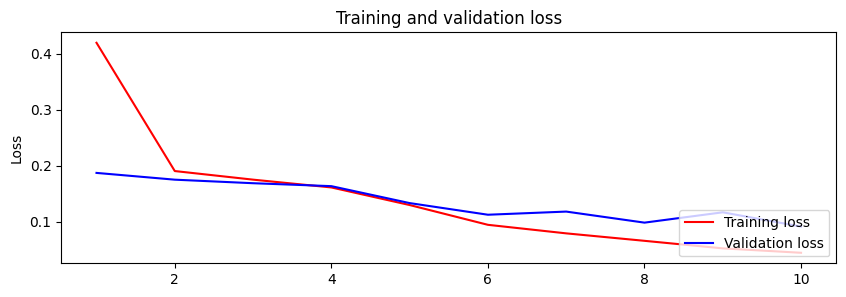

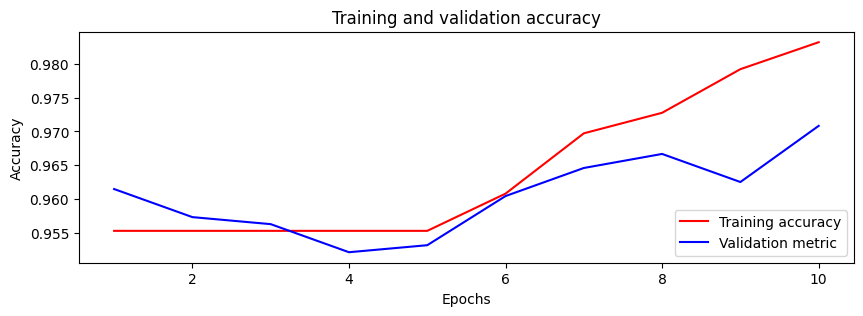

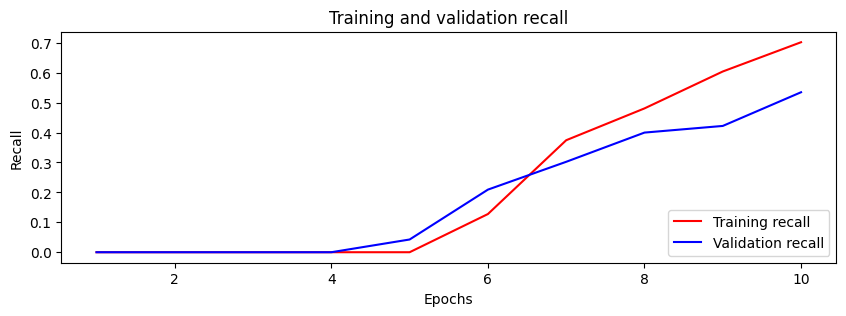

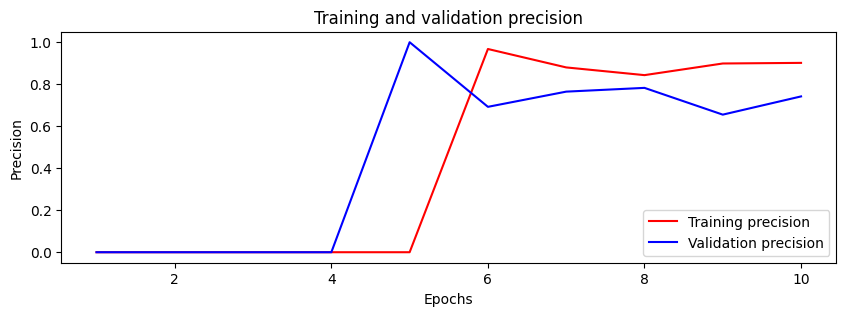

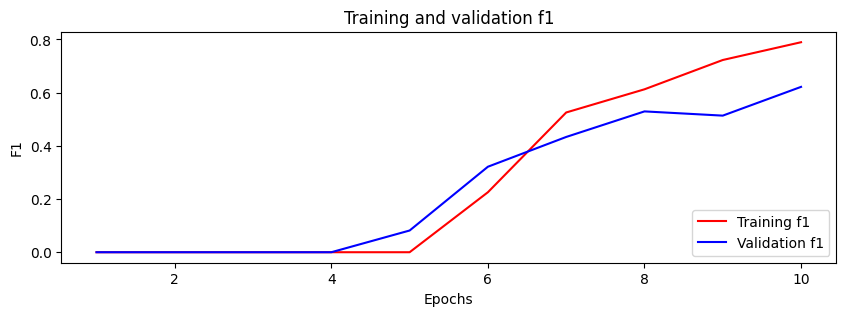

In [20]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

accuracy = history_dict['binary_accuracy']
val_accuracy = history_dict['val_binary_accuracy']

recall = history_dict['recall']
val_recall = history_dict['val_recall']

precision = history_dict['precision']
val_precision = history_dict['val_precision']

f1 = [0 if i+j==0 else 2 * i * j / (i + j) if (i + j) > 0 else None for i,j in zip(recall, precision) ]
val_f1 = [0 if i+j==0 else 2 * i * j / (i + j) if (i + j) > 0 else None for i,j in zip(val_recall, val_precision)]

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation metric')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, f1, 'r', label='Training f1')
plt.plot(epochs, val_f1, 'b', label='Validation f1')
plt.title('Training and validation f1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend(loc='lower right')
plt.show()
plt.close()

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [21]:
sample_text = ('Bank of America hit with $250M in fines and refunds for double-dipping fees and fake accounts.')
predictions = model.predict(np.array([sample_text]))
predictions

1/1 [==============================] - 3s 3s/step


array([[-5.4388514]], dtype=float32)

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=metrics)

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
165/165 [==============================] - 43s 150ms/step - loss: 0.4030 - binary_accuracy: 0.9567 - recall: 0.1089 - precision: 0.7021 - val_loss: 0.1949 - val_binary_accuracy: 0.9542 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
165/165 [==============================] - 7s 43ms/step - loss: 0.2056 - binary_accuracy: 0.9553 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.1869 - val_binary_accuracy: 0.9542 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/10
165/165 [==============================] - 7s 41ms/step - loss: 0.1909 - binary_accuracy: 0.9553 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.1786 - val_binary_accuracy: 0.9542 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/10
165/165 [==============================] - 6s 36ms/step - loss: 0.1767 - binary_accuracy: 0.9553 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.1524 - val_binary_accuracy: 0.9542 - val_recall: 0.0000e+00 - val_precisio

In [25]:
loss, accuracy, recall, precision = model.evaluate(test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1: {0 if (recall + precision)==0 else 2 * recall * precision / (recall + precision)}')

41/41 [==============================] - 1s 19ms/step - loss: 0.1455 - binary_accuracy: 0.9596 - recall: 0.3971 - precision: 0.6923
Loss: 0.1454717218875885
Accuracy: 0.9596036672592163
Recall: 0.3970588147640228
Precision: 0.692307710647583
F1: 0.5046728949888748


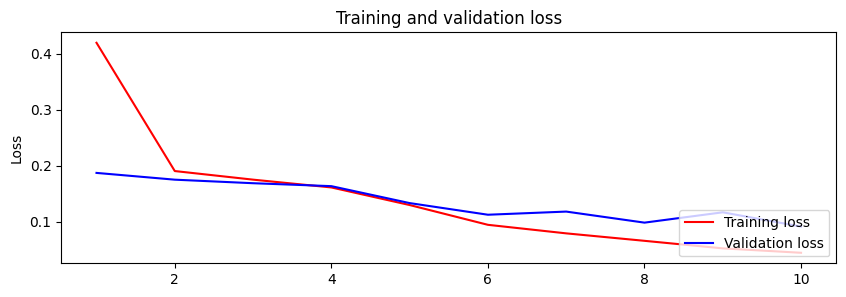

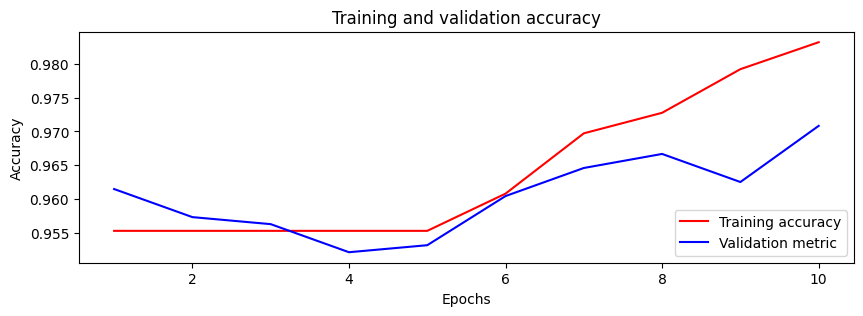

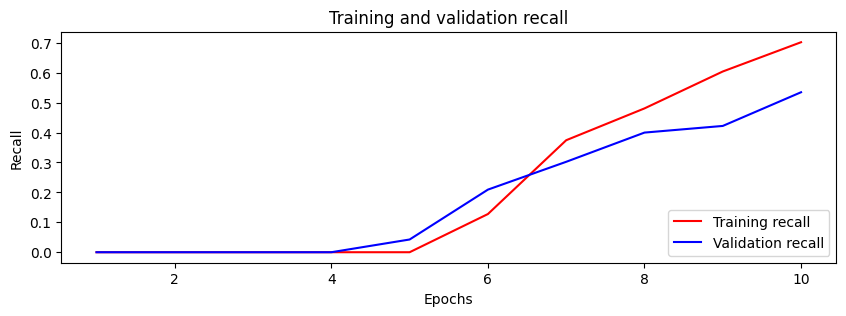

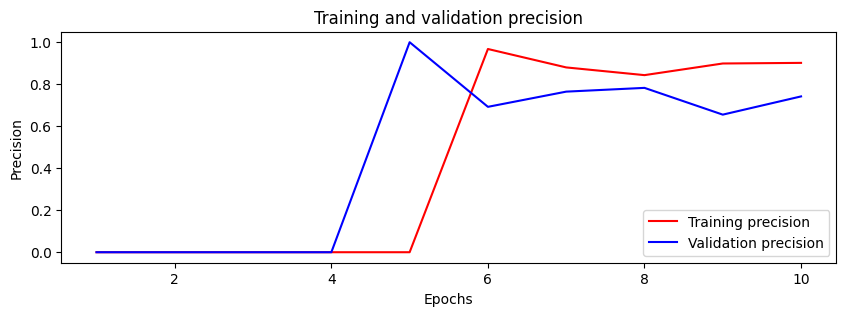

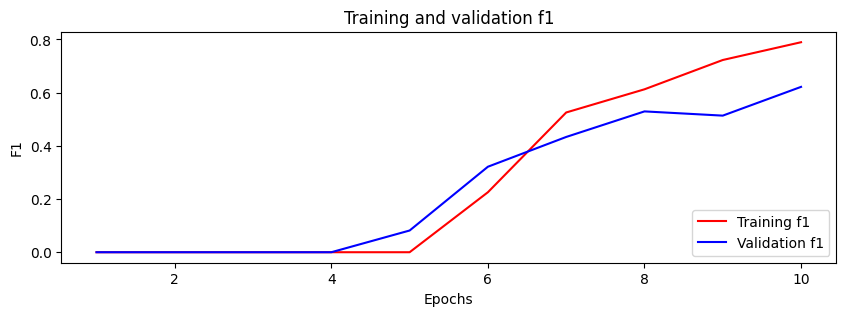

In [26]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

accuracy = history_dict['binary_accuracy']
val_accuracy = history_dict['val_binary_accuracy']

recall = history_dict['recall']
val_recall = history_dict['val_recall']

precision = history_dict['precision']
val_precision = history_dict['val_precision']

f1 = [0 if i+j==0 else 2 * i * j / (i + j) if (i + j) > 0 else None for i,j in zip(recall, precision) ]
val_f1 = [0 if j+j==0 else 2 * i * j / (i + j) if (i + j) > 0 else None for i,j in zip(val_recall, val_precision)]

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation metric')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, f1, 'r', label='Training f1')
plt.plot(epochs, val_f1, 'b', label='Validation f1')
plt.title('Training and validation f1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend(loc='lower right')
plt.show()
plt.close()